**ЗАГРУЗКА БИБЛИОТЕК И ДАННЫХ**

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import chi2_contingency

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_file_path = '/content/drive/MyDrive/Credit Score/train.csv'

In [ ]:
train_data = pd.read_csv(train_file_path)

**ПРОВЕДЕНИЕ РАЗВЕДОЧНОГО АНАЛИЗА**

In [ ]:
class CreditScoringEDA:
    def __init__(self, dataframe):
        self.df = dataframe

    def basic_statistics(self):
        """Display basic statistics of the dataset."""
        print("Basic Info:")
        print(self.df.info())
        print("\nSummary Statistics:")
        print(self.df.describe())
        print(self.df.describe(include=['O']))

    def plot_missing_values(self):
        """Visualize missing values in the dataset."""
        missing = self.df.isnull().mean() * 100
        missing = missing[missing > 0].sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=missing.index, y=missing.values)
        plt.xticks(rotation=45)
        plt.ylabel("Percentage of Missing Values")
        plt.title("Missing Values by Column")
        plt.xlabel("")
        plt.show()

    def plot_numerical_distributions(self):
        """Plot distributions for numerical columns."""
        numerical_cols = self.df.select_dtypes(include=['float64', 'int64']).columns
        self.df[numerical_cols].hist(figsize=(15, 10), bins=20, edgecolor='black')
        plt.suptitle("Distributions of Numerical Features", size=16)
        plt.show()

    def plot_categorical_distributions(self):
        """Plot distributions for categorical columns."""
        categorical_cols = self.df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if self.df[col].nunique() < 20:  # Для колонок с небольшим числом уникальных значений
                plt.figure(figsize=(8, 4))
                sns.countplot(data=self.df, x=col, order=self.df[col].value_counts().index)
                plt.xticks(rotation=45)
                plt.title(f"Distribution of {col}")
                plt.show()

In [ ]:
eda = CreditScoringEDA(train_data)
eda.basic_statistics()

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 n

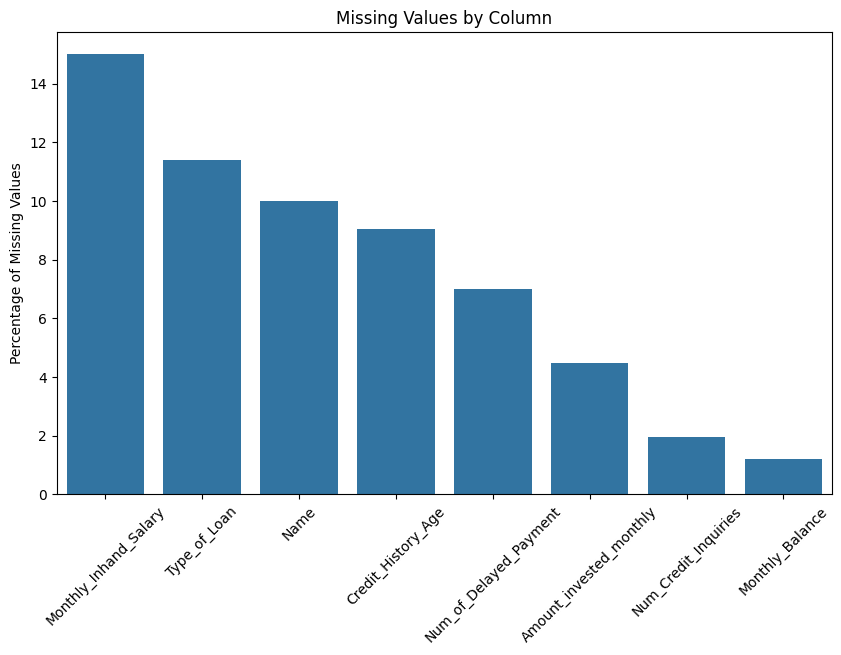

In [ ]:
eda.plot_missing_values()

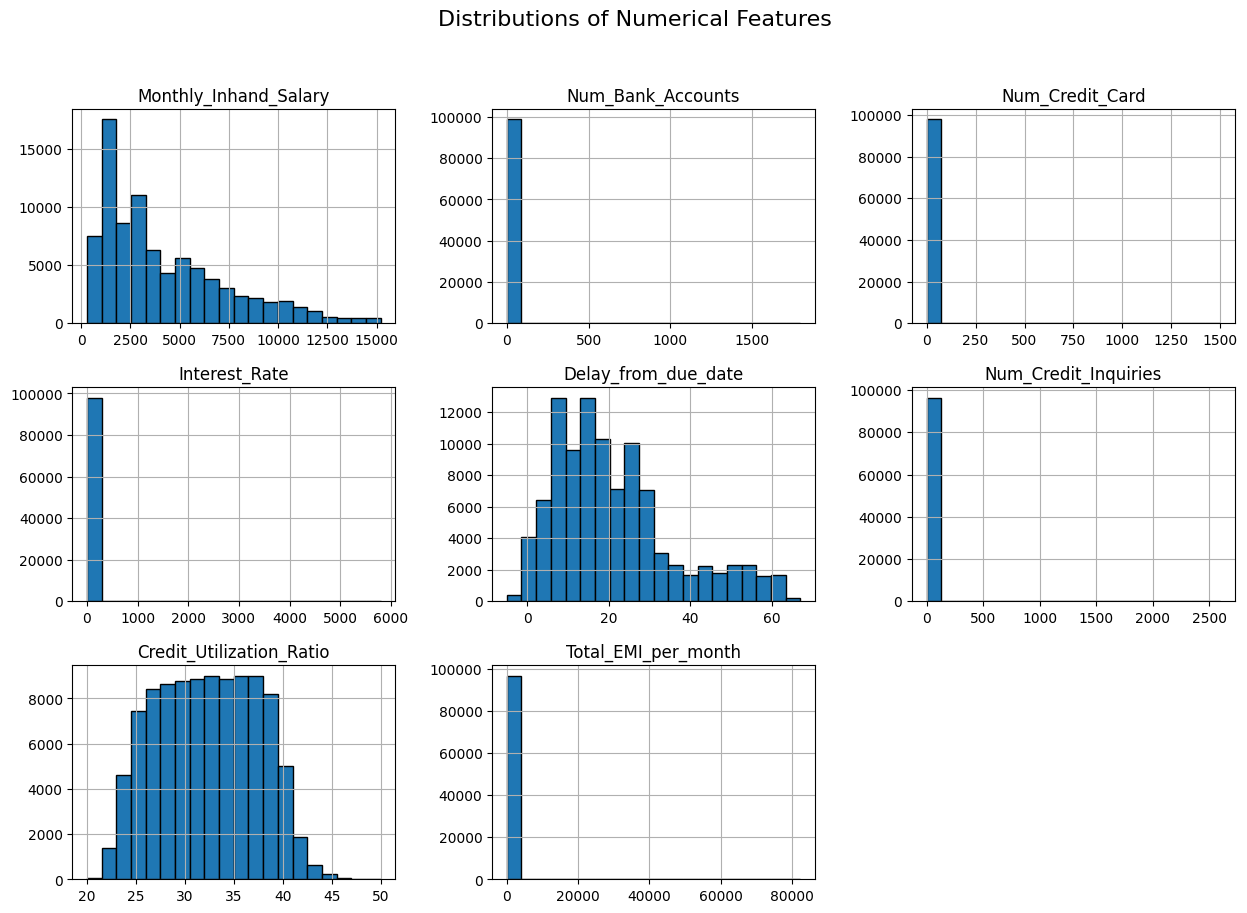

In [ ]:
eda.plot_numerical_distributions()

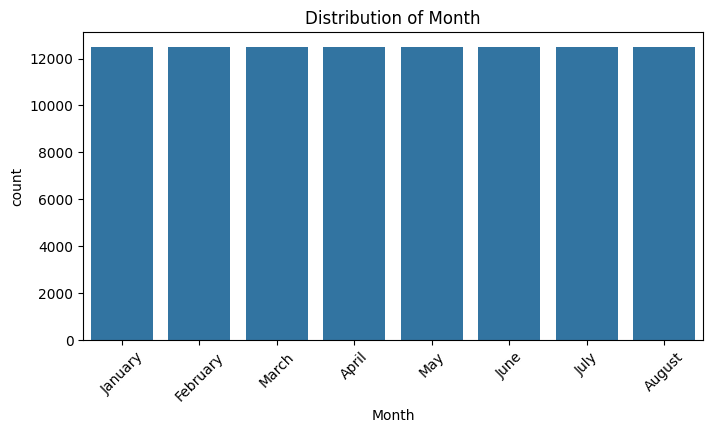

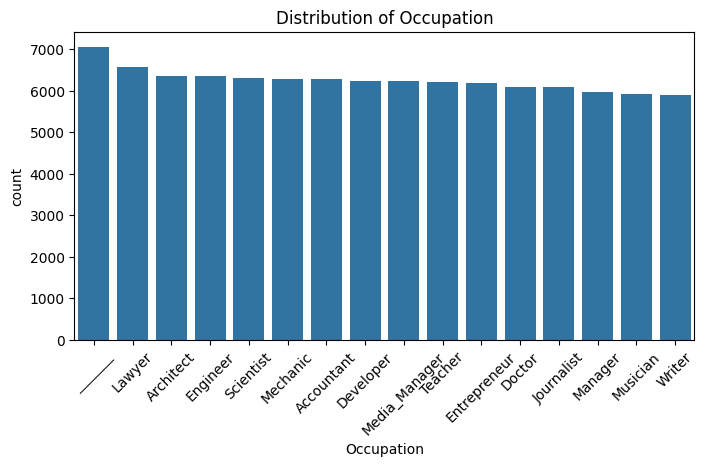

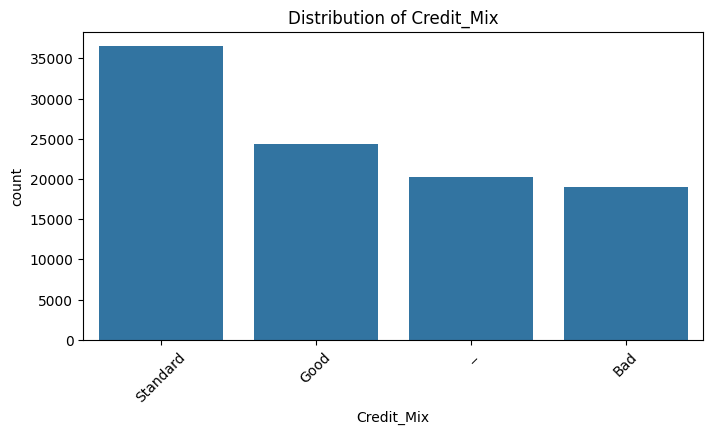

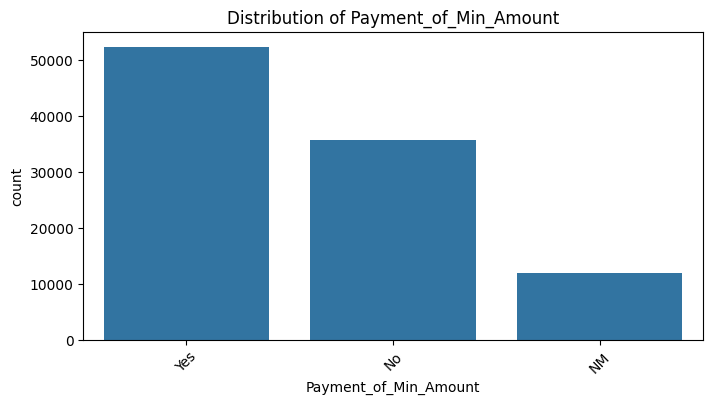

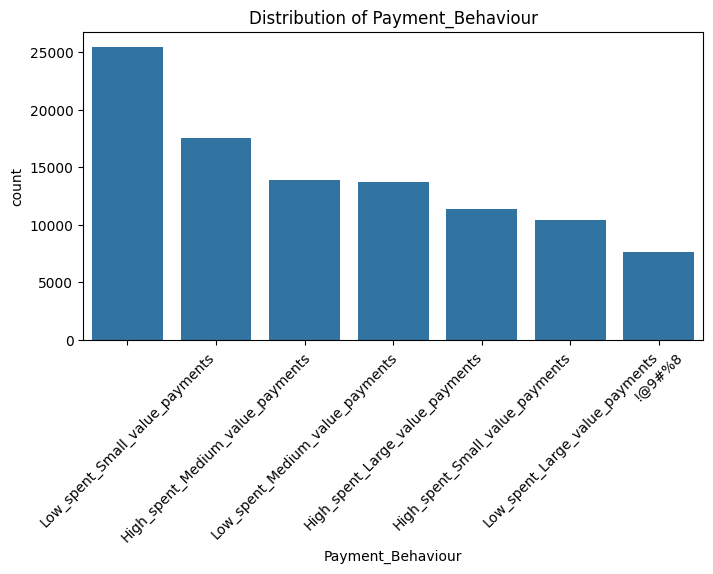

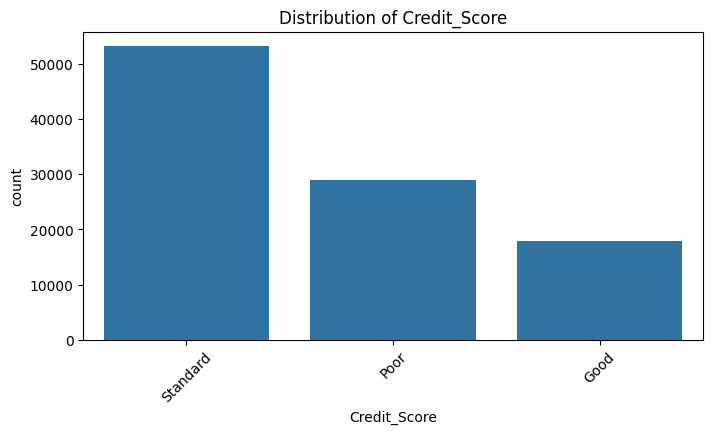

In [ ]:
eda.plot_categorical_distributions()

**ОЧИСТКА ДАННЫХ**  


*   Удаление ненужных колонок
*   Приведение данных к правильному типу
*   Обработка некорректных значений
*   Работа с выбросами
*   Работа с пропущенными данными




In [ ]:
class DataCleaner:
    def __init__(self, dataframe):
        self.df = dataframe

    def preprocess_columns(self):
        """Remove unnecessary columns and adjust data types."""
        self.df.drop(columns=['ID', 'Customer_ID', 'Month', 'Name'], inplace=True, errors='ignore')

        self.df['Annual_Income'] = pd.to_numeric(self.df['Annual_Income'], errors='coerce').round(4)
        self.df['Num_of_Loan'] = pd.to_numeric(self.df['Num_of_Loan'], errors='coerce').fillna(0).astype(int)
        self.df['Delay_from_due_date'] = self.df['Delay_from_due_date'].clip(lower=0)
        self.df['Num_of_Delayed_Payment'] = pd.to_numeric(self.df['Num_of_Delayed_Payment'], errors='coerce').fillna(0).astype(int)
        self.df['Outstanding_Debt'] = pd.to_numeric(self.df['Outstanding_Debt'], errors='coerce').round(4)
        self.df['Amount_invested_monthly'] = pd.to_numeric(self.df['Amount_invested_monthly'], errors='coerce').round(4)
        self.df['Monthly_Balance'] = pd.to_numeric(self.df['Monthly_Balance'], errors='coerce').round(4)
        self.df['Changed_Credit_Limit'] = pd.to_numeric(self.df['Changed_Credit_Limit'], errors='coerce').round(4)

        self.df['Age'] = pd.to_numeric(self.df['Age'], errors='coerce')
        median_age = self.df.loc[self.df['Age'] >= 0, 'Age'].median()
        self.df['Age'] = self.df['Age'].apply(lambda x: median_age if x < 0 else (100 if x > 100 else x)).astype('Int64')

    def clean_numerical(self):
        """Clean numerical columns (handle negatives and outliers)."""
        for col in self.df.select_dtypes(include=['float64', 'int64']).columns:
            if col not in ['Credit_Score']:
                self.df.loc[:, col] = self.df[col].clip(lower=0)

    def clean_categorical(self):
        """Validate and clean categorical columns."""
        if 'Occupation' in self.df.columns:
            self.df.loc[:, 'Occupation'] = self.df['Occupation'].replace('_______', 'Other')

        if 'Payment_of_Min_Amount' in self.df.columns:
            self.df.loc[:, 'Payment_of_Min_Amount'] = self.df['Payment_of_Min_Amount'].replace('NM', 'No')

        if 'Payment_Behaviour' in self.df.columns:
            self.df.loc[:, 'Payment_Behaviour'] = self.df['Payment_Behaviour'].replace('!@9#%8', 'Other')

        if 'SSN' in self.df.columns:
            self.df.loc[:, 'SSN'] = self.df['SSN'].apply(lambda x: x if isinstance(x, str) and len(x.split('-')) == 3 else 'No')

    def convert_credit_history_age(self):
        """Convert Credit_History_Age from text to months."""
        def to_months(age):
            if isinstance(age, str):
                years, months = 0, 0
                if "Years" in age:
                    years = int(age.split(" Years")[0])
                if "Months" in age:
                    months = int(age.split("and ")[-1].split(" Months")[0])
                return years * 12 + months
            return None

        self.df.loc[:, 'Credit_History_Age'] = self.df['Credit_History_Age'].apply(to_months).astype('Int64')

    def handle_missing_values(self):
        """Fill missing values based on strategy."""
        for col in self.df.columns:
            if self.df[col].dtype in ['float64', 'int64']:
                self.df.loc[:, col] = self.df[col].fillna(self.df[col].median())
            else:
                self.df.loc[:, col] = self.df[col].fillna(self.df[col].mode()[0])

    def execute_cleaning(self):
        """Execute all cleaning steps."""
        self.preprocess_columns()
        self.clean_numerical()
        self.clean_categorical()
        self.convert_credit_history_age()
        self.handle_missing_values()
        return self.df


In [ ]:
train_cleaner = DataCleaner(train_data)
train_clean_data = train_cleaner.execute_cleaning()

In [ ]:
pd.set_option('display.max_columns', None)
test_clean_data.head()

,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,2022.0,Good,809.98,35.030402,273,No,49.574949,236.6427,Low_spent_Small_value_payments,186.2667
1,24,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,13.27,4.0,Good,809.98,33.053114,274,No,49.574949,21.4654,High_spent_Medium_value_payments,361.4440
2,24,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",0,4,12.27,4.0,Good,809.98,33.811894,193,No,49.574949,148.2339,Low_spent_Medium_value_payments,264.6754
3,34,821-00-0265,Scientist,19114.12,3086.305000,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,11.27,4.0,Good,809.98,32.430559,276,No,49.574949,39.0825,High_spent_Medium_value_payments,343.8269
4,28,004-07-5839,Other,34847.84,3037.986667,2,4,6,1,Credit-Builder Loan,3,1,5.42,5.0,Good,605.03,25.926822,327,No,18.816215,39.6840,High_spent_Large_value_payments,485.2984


Проверка важности признаков

In [ ]:
# X = clean_data.drop(columns=['Credit_Score'])
# y = clean_data['Credit_Score']

# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

# chi2_scores, p_values = chi2(X_scaled, y_encoded)

# chi2_results = pd.DataFrame({
#     'Feature': X.select_dtypes(include=['float64', 'int64']).columns,
#     'Chi2 Score': chi2_scores,
#     'P-value': p_values
# }).sort_values(by='Chi2 Score', ascending=False)

# print("Top features based on Chi2 Test:")
# print(chi2_results.head())

In [ ]:
# categorical_cols = X.select_dtypes(include=['object', 'category']).columns
# contingency_results = []

# for col in categorical_cols:
#     contingency_table = pd.crosstab(X[col], y)
#     chi2_stat, p, _, _ = chi2_contingency(contingency_table)
#     contingency_results.append({'Feature': col, 'Chi2 Score': chi2_stat, 'P-value': p})

# categorical_results = pd.DataFrame(contingency_results).sort_values(by='Chi2 Score', ascending=False)
# print("\nTop categorical features based on Chi2 Contingency Test:")
# print(categorical_results.head())

**ПОСТРОЕНИЕ МОДЕЛИ CATBOOST**

In [ ]:
X = clean_data.drop(columns=['Credit_Score'])
y = clean_data['Credit_Score']

categorical_features = list(X.select_dtypes(include=['object', 'category']).columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

In [ ]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_features,
    verbose=50,
    random_seed=7
)

In [ ]:
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

0:	learn: 1.0342135	test: 1.0348857	best: 1.0348857 (0)	total: 332ms	remaining: 2m 45s
50:	learn: 0.5264321	test: 0.4498025	best: 0.4498025 (50)	total: 14.8s	remaining: 2m 10s
100:	learn: 0.5088729	test: 0.4346670	best: 0.4346670 (100)	total: 30.6s	remaining: 2m 1s
150:	learn: 0.5003492	test: 0.4302567	best: 0.4302567 (150)	total: 46.8s	remaining: 1m 48s
200:	learn: 0.4942236	test: 0.4273581	best: 0.4273581 (200)	total: 1m 3s	remaining: 1m 34s
250:	learn: 0.4899994	test: 0.4261266	best: 0.4261266 (250)	total: 1m 19s	remaining: 1m 19s
300:	learn: 0.4860472	test: 0.4249743	best: 0.4249743 (300)	total: 1m 37s	remaining: 1m 4s
350:	learn: 0.4816658	test: 0.4233673	best: 0.4233673 (350)	total: 1m 54s	remaining: 48.6s
400:	learn: 0.4780302	test: 0.4228095	best: 0.4227618 (399)	total: 2m 11s	remaining: 32.4s
450:	learn: 0.4744026	test: 0.4222655	best: 0.4222653 (447)	total: 2m 27s	remaining: 16.1s
499:	learn: 0.4712258	test: 0.4219304	best: 0.4219304 (499)	total: 2m 44s	remaining: 0us

bestTe

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

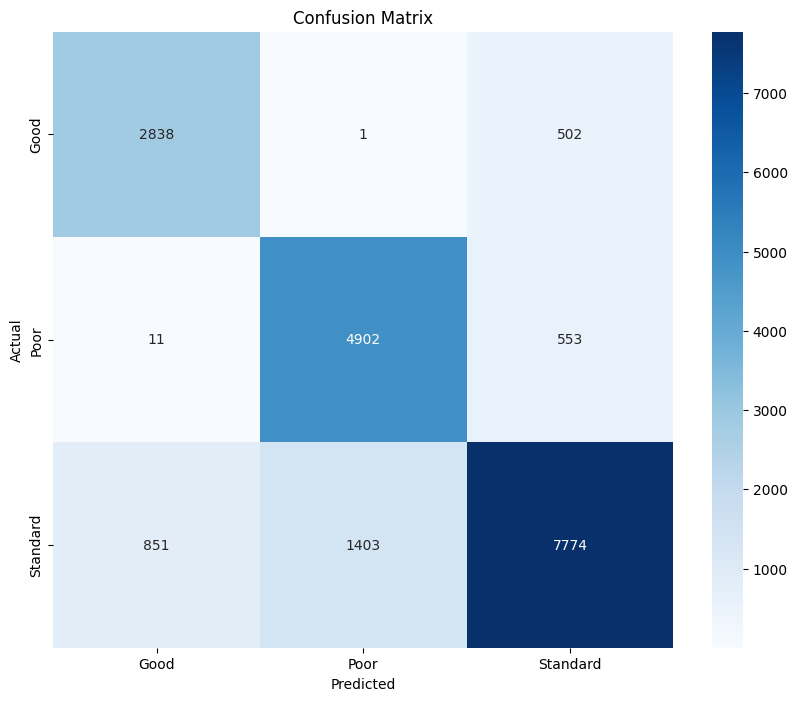

In [ ]:
class_names = ["Good", "Poor", "Standard"]

plot_confusion_matrix(y_test, y_pred, class_names)

In [ ]:
from joblib import dump
dump(model, '/content/drive/MyDrive/Credit Score/credit_score_model.pkl')

['/content/drive/MyDrive/Credit Score/credit_score_model.pkl']